# Homework 1

In [139]:
import pandas as pd
import random
import math

import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

The data is composed by...

In [140]:
df = pd.read_csv('data/applications_of_DM.csv', sep=',')
df

,title,text
0,Anomaly Detection at Multiple Scales,"Anomaly Detection at Multiple Scales, or ADAMS..."
1,Behavioral analytics,Behaviorism is a systematic approach to unders...
2,Business analytics,Business analysis is a professional discipline...
3,CORE (research service),CORE (Connecting Repositories) is a service pr...
4,Daisy Intelligence,Daisy Intelligence is a Canadian Artificial In...
5,Data Applied,Data Applied is a software vendor headquartere...
6,Data mining in agriculture,Data mining in agriculture is a recent researc...
7,Data thinking,"Data thinking is a buzzword for the generic ""m..."
8,Document processing,Document processing is a field of research and...
9,Equifax Workforce Solutions,"Equifax Workforce Solutions, formerly known as..."


## First task (Shingling)

In [141]:
class Shingling:
    def __init__(self, k):
        self.k = k  # The length of the shingle
        self.N = 2 ** 32 - 1

    def shingle_document(self, document):
        shingles = set()
        for i in range(len(document) - self.k + 1):
            shingle = document[i:i + self.k]
            hash_val = hash(shingle) % self.N
            shingles.add(hash_val)
        return shingles

class CompareSets:
    def jaccard_similarity(set1, set2):
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union)

class MinHashing:
    def __init__(self, k, num_shingles):
        self.k = k  # The length of the signature
        self.num_shingles = num_shingles # c
        self.coefficients = [(random.randint(0, num_shingles), random.randint(0, num_shingles)) for _ in range(k)]

    def minhash(self, shingles):
        signature = []
        for a, b in self.coefficients:
            min_hash = min([(a * shingle + b) % self.num_shingles for shingle in shingles])
            signature.append(min_hash)
        return signature

class CompareSignatures:
    def jaccard_similarity(sig1, sig2):
        intersection = 0
        for i in range(len(sig1)):
            if sig1[i] == sig2[i]:
                intersection += 1
        return intersection / len(sig1)


Let us now test the Shingling with a dummy example. We took $K=3$ because of the shortness of the documents in the example. With increasing k-s the less similar the documents are going to be, since we are anlyzing larger chunks and it is more rare to have similar chunks of that size, while it is easier to have 1-grams, 2-grams in common.

In [142]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=3)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.8108108108108109
Jaccard similarity between doc1 and doc3 is:  0.05263157894736842
Jaccard similarity between doc2 and doc3 is:  0.02531645569620253


Let us now try with $k=1$. We expect to have higher similarities even if the documents d1-d3 and d2-d3 are completely different.

In [143]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=1)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.9333333333333333
Jaccard similarity between doc1 and doc3 is:  0.55
Jaccard similarity between doc2 and doc3 is:  0.6


Let us now test the MinHashing class and methods on the same dummy example presented before.

In [144]:
# Get the shingles for each document
shingling = Shingling(k=3)
documents = [doc1, doc2, doc3]

shingles = [shingling.shingle_document(document) for document in documents] # Get the total number of shingles
num_shingles = len(set().union(*shingles)) # This is the c parameter of the hash functions

print("Total number of shingles across all documents", num_shingles)

Total number of shingles across all documents 80


Now, we need to choose k wisely, as random guesses would not end up in good results. $K=1$ is too small and the expected error is too high. Larger k-s are better, as we can potentially reach the original number of shingles (rows of the shingles x documents matrix) and minimize the error. However, the computational cost is too high. We need to find a trade-off between the two. We can try with $K=20\%$ of the document with the highest number of shingles (length of the shingles x documents matrix).

In [145]:
len(shingles3) # The document with the longest shingle set

17

In [146]:
int(len(shingles3) / 100 * 20) # The number of hash functions we need to use

3

In [147]:
min_hashing = MinHashing(k=3, num_shingles=num_shingles)

minhashes1 = min_hashing.minhash(shingles[0])
minhashes2 = min_hashing.minhash(shingles[1])
minhashes3 = min_hashing.minhash(shingles[2])

print("Jaccard similarity between doc1 and doc2 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes2, minhashes3))

Jaccard similarity between doc1 and doc2 is:  1.0
Jaccard similarity between doc1 and doc3 is:  0.3333333333333333
Jaccard similarity between doc2 and doc3 is:  0.3333333333333333


Let us now run all the classes and methods for the real data.

In [148]:
# Compute the shingles
shingling = Shingling(k=10) # k=10 as suggested on the slides (good for long documents)

shingles = {}

for i, row in df.iterrows():
    shingles[i] = shingling.shingle_document(row['text'])

In [149]:
# Comput Jaccard Similarity with CompareSets
jaccard_similarities = pd.DataFrame(columns=[i for i in range(len(shingles))], index=[i for i in range(len(shingles))])

for i in shingles.keys():
    for j in shingles.keys():
        jaccard_similarities[i][j] = CompareSets.jaccard_similarity(shingles[i], shingles[j])

jaccard_similarities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.001207,0.002904,0.003248,0.001855,0.005913,0.003543,0.003479,0.00338,0.002326,0.0,0.003175,0.00292,0.00205,0.125341,0.004038,0.001618
1,0.001207,1.0,0.021238,0.007749,0.001221,0.001045,0.010497,0.00869,0.009149,0.006598,0.002467,0.002696,0.008556,0.021669,0.002325,0.023866,0.001055
2,0.002904,0.021238,1.0,0.012735,0.000933,0.002033,0.011302,0.018505,0.011906,0.009941,0.001652,0.00262,0.010797,0.02149,0.004583,0.025455,0.001638
3,0.003248,0.007749,0.012735,1.0,0.001968,0.005511,0.009624,0.012402,0.008999,0.007879,0.004857,0.004045,0.007267,0.010009,0.005629,0.016434,0.003838
4,0.001855,0.001221,0.000933,0.001968,1.0,0.01227,0.002007,0.001521,0.002162,0.005553,0.0,0.002731,0.004671,0.000926,0.002863,0.00227,0.004062
5,0.005913,0.001045,0.002033,0.005511,0.01227,1.0,0.003783,0.008621,0.005142,0.005002,0.00401,0.00172,0.00351,0.001285,0.010035,0.004937,0.003051
6,0.003543,0.010497,0.011302,0.009624,0.002007,0.003783,1.0,0.010423,0.015448,0.005411,0.003683,0.008784,0.010321,0.011102,0.006026,0.014685,0.002606
7,0.003479,0.00869,0.018505,0.012402,0.001521,0.008621,0.010423,1.0,0.010387,0.008197,0.003969,0.007989,0.006265,0.005671,0.005647,0.011839,0.002773
8,0.00338,0.009149,0.011906,0.008999,0.002162,0.005142,0.015448,0.010387,1.0,0.006221,0.00248,0.006542,0.003469,0.01037,0.005167,0.022387,0.000996
9,0.002326,0.006598,0.009941,0.007879,0.005553,0.005002,0.005411,0.008197,0.006221,1.0,0.001817,0.002396,0.003986,0.00814,0.003537,0.010445,0.004398


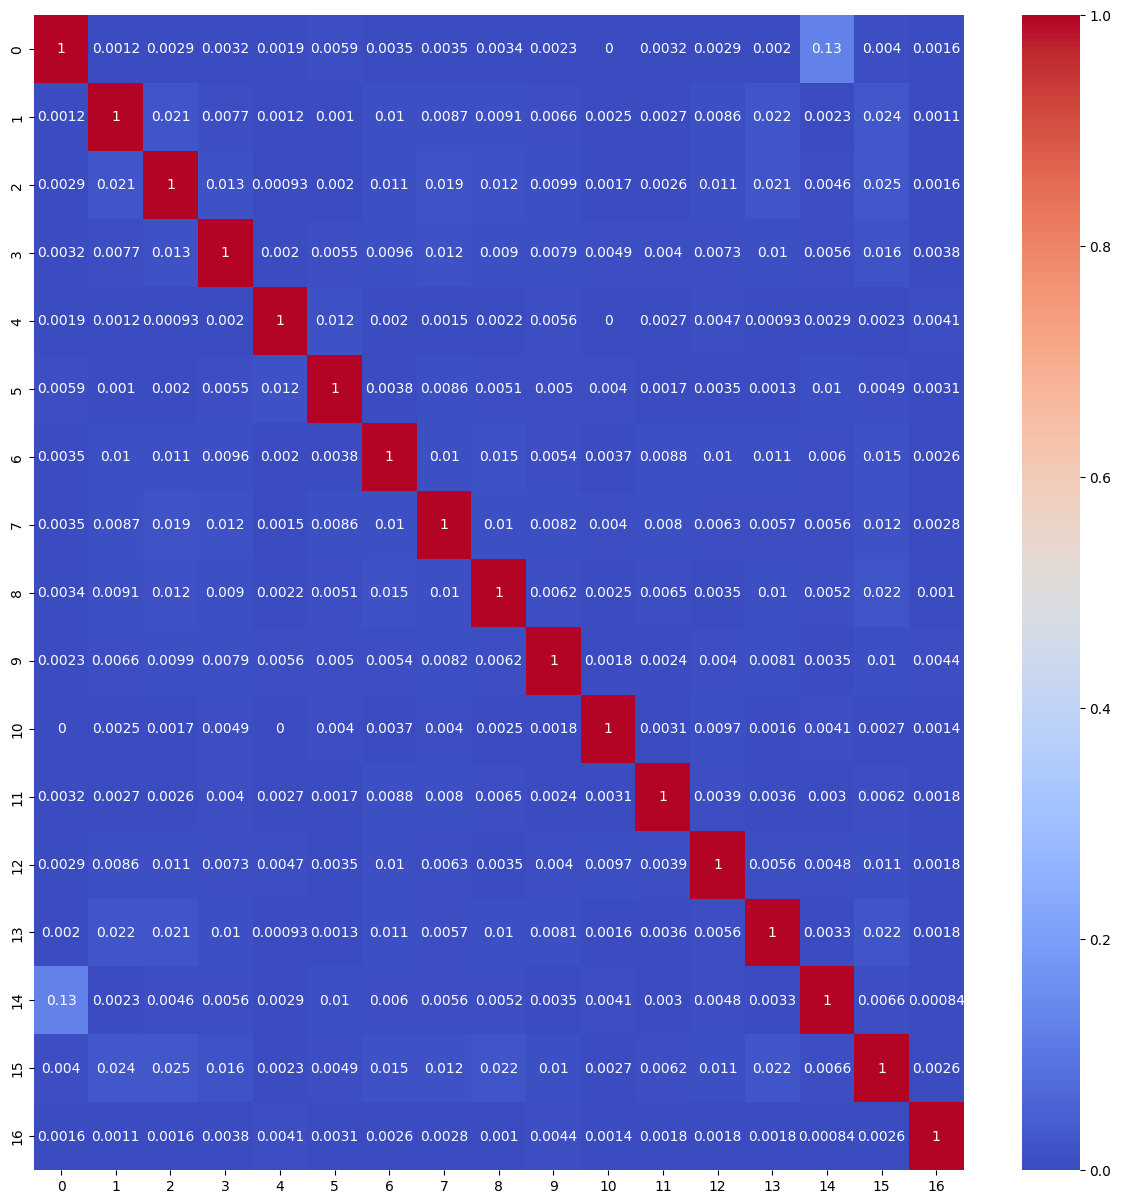

In [150]:
# Heatmap of the Jaccard Similarities
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities.astype(float), cmap='coolwarm', annot=True)
plt.show()

Let us now proceed with the MinHashing class and methods on the real data.

In [151]:
# Get the shingles for each document
shingling = Shingling(k=10)
documents = df["text"]
shingles = [shingling.shingle_document(document) for document in documents] # Get the number of shingles
num_shingles = len(set().union(*shingles))
print("Number of shingles", num_shingles)

Number of shingles 135498


In [152]:
# Find the document with the longest shingle set (lenght of the shingles x documents matrix)
max = 0
for i in range(len(shingles)):
    if len(shingles[i]) > max:
        max = len(shingles[i])

print("The document with the longest shingle set has", max, "shingles")

The document with the longest shingle set has 41537 shingles


In [153]:
# Compute the min hashes
k = int(max/100*20)
print("We will use", k, "hash functions")
min_hashing = MinHashing(k=k, num_shingles=num_shingles) # Take k as 20% of the longest shingle set

min_hashes = {}

for shingle in shingles:
    min_hashes[i] = min_hashing.minhash(shingle)

We will use 8307 hash functions


In [ ]:
# Comput Jaccard Similarity with CompareSignatures
jaccard_similarities_min_hashing = pd.DataFrame(columns=[i for i in range(len(shingles))], index=[i for i in range(len(shingles))])

for i in shingles.keys():
    for j in shingles.keys():
        jaccard_similarities[i][j] = CompareSignatures.jaccard_similarities_min_hashing(shingles[i], shingles[j])

jaccard_similarities_min_hashing

In [ ]:
# Heatmap of the Jaccard Similarities with Min Hashing
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities_min_hashing.astype(float), cmap='coolwarm', annot=True)
plt.show()